In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader
from transformers import BatchEncoding, BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import confusion_matrix
from datasets import load_dataset
from tqdm import tqdm
from typing import TypedDict

/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
dataset = load_dataset("ag_news")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

class DatasetItem(TypedDict):
    text: str
    label: str


def preprocess_data(dataset_item: DatasetItem) -> dict[str, torch.Tensor]:
    return tokenizer(dataset_item["text"], truncation=True, padding="max_length", return_tensors="pt")


train_dataset = dataset["train"].select(range(1200)).map(preprocess_data, batched=True)
test_dataset = dataset["test"].select(range(800)).map(preprocess_data, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

/Library/Python/3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Python/3.9/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3
losses: list[float] = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        inputs = {key: batch[key].to(device) for key in batch}
        labels = inputs.pop("label")
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {average_loss}")

Epoch 1: 100%|██████████| 150/150 [12:55<00:00,  5.17s/it]


Epoch 1, Average Loss: 0.6272634619474411


Epoch 2: 100%|██████████| 150/150 [13:11<00:00,  5.27s/it]


Epoch 2, Average Loss: 0.2985887332384785


Epoch 3: 100%|██████████| 150/150 [12:05<00:00,  4.84s/it]

Epoch 3, Average Loss: 0.19837265202154716


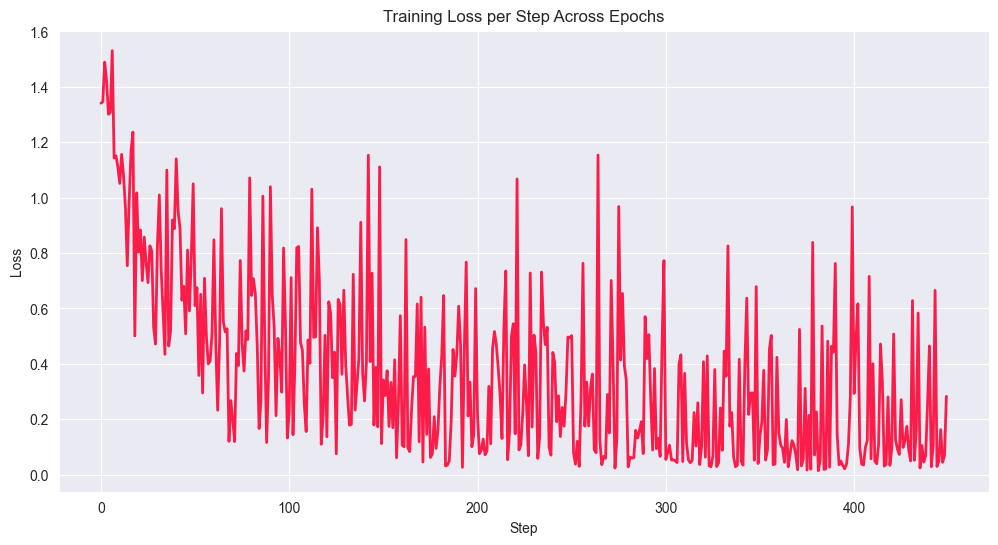

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(losses, color="#f"
                       "c1c49", linewidth=2)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss per Step Across Epochs")
plt.show()

In [6]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        inputs = {key: batch[key].to(device) for key in batch}
        labels = inputs.pop("label")
        outputs = model(**inputs, labels=labels)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        correct += (predicted_labels == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total

print("")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Evaluating: 100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


Test Accuracy: 85.62%


In [7]:
all_predictions: list[int] = []
all_labels: list[int] = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        inputs = {key: batch[key].to(device) for key in batch}
        labels = inputs.pop("label")
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Evaluating: 100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


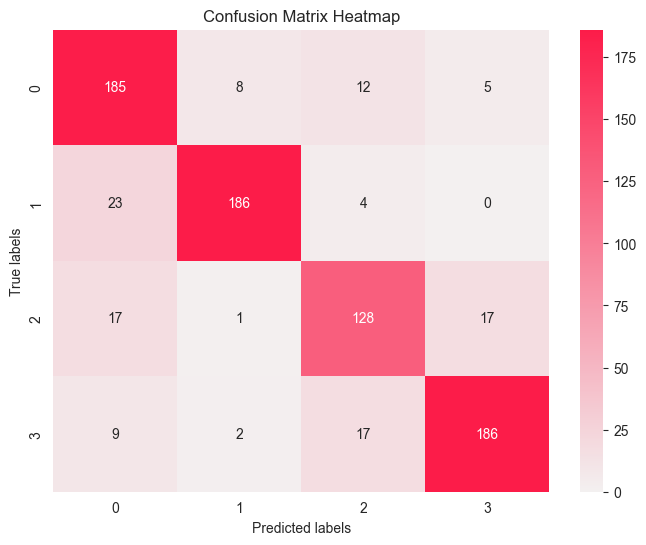

In [8]:
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap=sns.light_palette("#fc1c49", as_cmap=True))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [9]:
# 모델 체크포인트 저장.
model_save_path = "bert_news_classification_model.pth"
torch.save(model.state_dict(), model_save_path)

In [17]:
# model_handler.py
!cat > model_handler.py <<EOF

import json
import torch
from ts.context import Context
from ts.torch_handler.base_handler import BaseHandler
from transformers import BatchEncoding, BertTokenizer, BertForSequenceClassification

class ModelHandler(BaseHandler):
    def __init__(self):
        self.initialized = False
        self.tokenizer = None
        self.model = None

    def initialize(self, context: Context):
        self.initialized = True
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
        self.model.load_state_dict(torch.load("bert_news_classification_model.pth"))
        self.model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        self.model.eval()

    def preprocess(self, data: list[dict[str, bytearray]]) -> BatchEncoding:
        model_input_texts: list[str] = sum([json.loads(item.get("body").decode("utf-8"))["data"] for item in data], [])
        inputs = self.tokenizer(model_input_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return inputs.to(device)

    def inference(self, input_batch: BatchEncoding) -> torch.Tensor:
        with torch.no_grad():
            outputs = self.model(**input_batch)
            return outputs.logits

    def postprocess(self, inference_output: torch.Tensor) -> list[dict[str, float]]:
        probabilities = torch.nn.functional.softmax(inference_output, dim=1)
        return [{"label": int(torch.argmax(prob)), "probability": float(prob.max())} for prob in probabilities]
EOF 

UsageError: Line magic function `%writefile` not found (But cell magic `%%writefile` exists, did you mean that instead?).


In [ ]:
# torch serve 설정 파일.

%%shell
cat > config.properties <<EOF
inference_address=http://0.0.0.0:5000
management_address=http://0.0.0.0:5001
metrics_address=http://0.0.0.0:5002
EOF

In [ ]:
# bert vocab 파일 (아티팩트)

!wget https://raw.githubusercontent.com/microsoft/SDNet/master/bert_vocab_files/bert-base-uncased-vocab.txt \
    -O bert-base-uncased-vocab.txt

In [ ]:
# Torch serve archiver의 최종 파일 저장 위치.
# .mar 확장자 파일을 생성하여 패키징 하게 된다.
!mkdir -p model-store

In [ ]:
!torch-model-archiver \
    --model-name bert_news_classification \
    --version 1.0 \
    --serialized-file bert_news_classification_model.pth \
    --handler ./model_handler.py \
    --extra-files "bert-base-uncased-vocab.txt" \
    --export-path model-store \
    -f

In [ ]:
%%script bash --bg
# 서버를 백그라운드에서 실행

PYTHONPATH=/usr/lib/python3.10 torchserve \
    --start \
    --ncs \
    --ts-config config.properties \
    --model-store model-store \
    --models bert_news_classification=bert_news_classification.mar

In [ ]:
# 아래와 같이 뜨면 정상 실행.
# {
#   "status": "Healthy"
# }

!curl -X GET localhost:5000/ping